In [327]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [328]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 16

# Size of feature maps in discriminator
ndf = 16

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

### Dataloader

torch.Size([32, 1, 512])


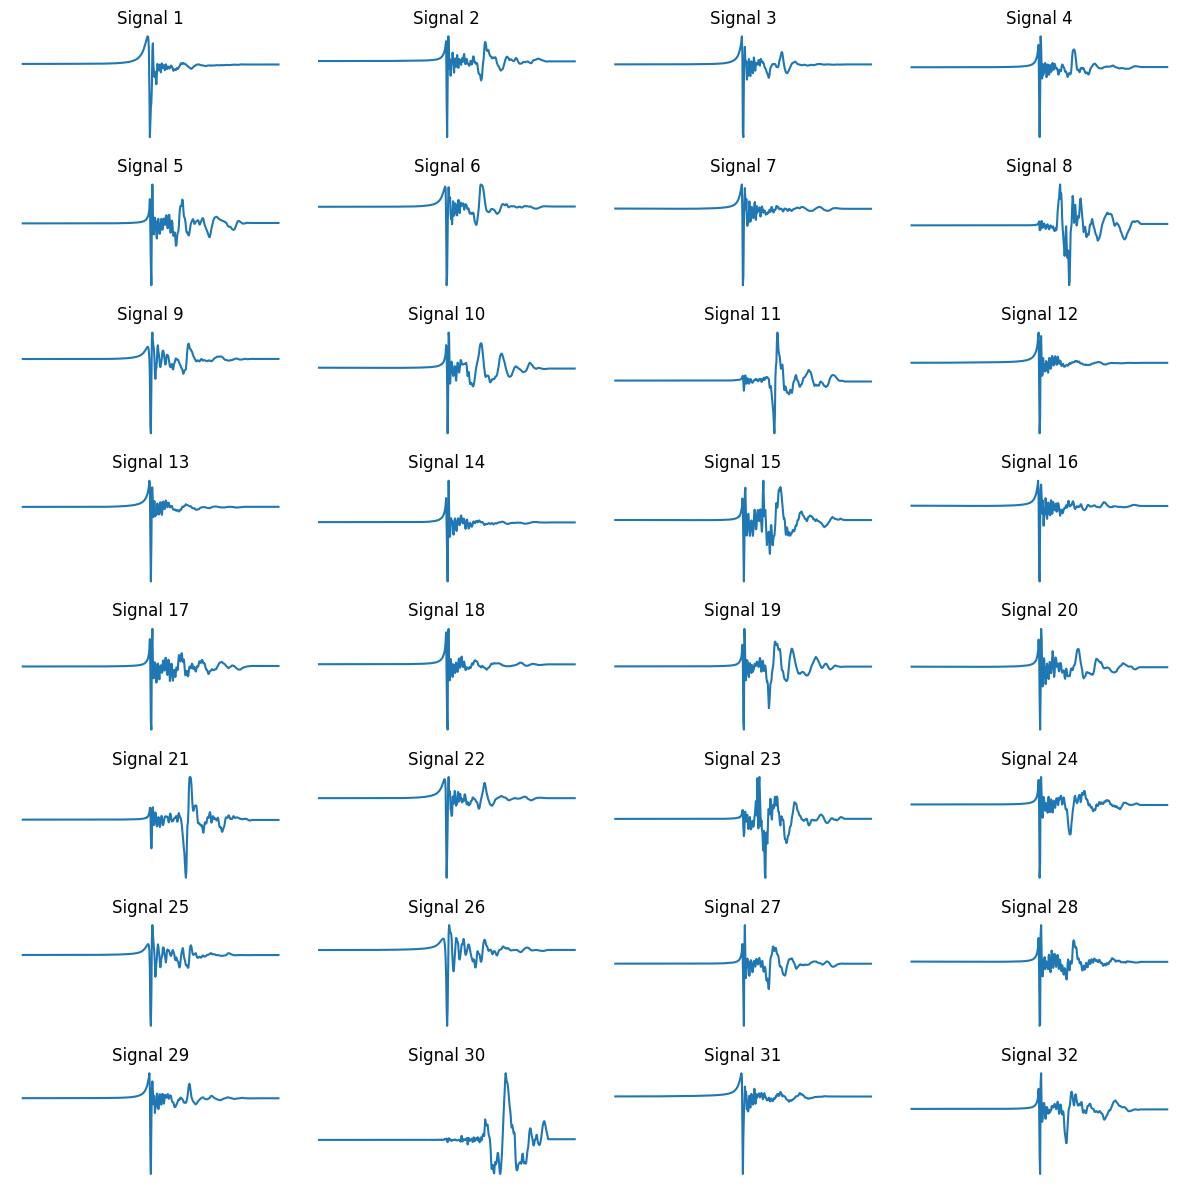

In [329]:
class GWDataset(Dataset):
    def __init__(self, csv_file):
        # self.data = pd.read_csv(csv_file)  # Save data as an instance attribute
        # self.transform = transform
        self.data = pd.read_csv(csv_file).astype('float32')

    def __len__(self):
        return len(self.data.columns)

    def __getitem__(self, idx):
        signal = self.data.iloc[:, idx].values
        signal = signal.reshape(1, -1)
        # reshape signal to have first 512 - 407 values to be 0.
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        # todo: pad similar values to front and end of signals

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        # print(signal_padded.shape)
        return signal_padded

dataset = GWDataset("../data/richers_1764.csv")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_batch = next(iter(dataloader))


# Expecting: (64, 1, 512)
print(real_batch.shape)  

# plotting a single batch
def plot_waveforms(batch):
    fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
    axs = axs.ravel()
    
    for i in range(len(batch)):
        signal = batch[i].squeeze()
        axs[i].plot(signal)
        axs[i].set_title(f'Signal {i+1}')
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_waveforms(real_batch)

### Weight Initialisation (Random Noise)

In [330]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [331]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(ngf * 64),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 32),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),

            # this squishes values between -1 and 1... we don't want that
            # nn.Tanh()
        )

    def forward(self, x):
        # print(x.shape)
        x = self.main(x)
        return x

In [332]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(100, 1024, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (13): BatchNorm1d(64, eps=1e-05, momentu

### Discriminator

In [333]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            # xl kernel, stride and padding on this one (first layer group)
            nn.Conv1d(nc, ndf, kernel_size=8, stride=4, padding=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),

            # xl kernel, stride and padding on this one (last layer group)
            nn.Conv1d(ndf * 32, 1, kernel_size=8,
                      stride=4, padding=2, bias=False),
            # nn.BatchNorm1d(ndf * 64),
            # nn.LeakyReLU(0.2, inplace=True),
        )

        # fully conencted layer to output probability
        self.fc = nn.Sequential(
            # nn.Linear(ndf * 64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y=None):
        # print(x.shape)
        x = self.main(x)
        # print(x.shape)
        # x = x.view(x.shape[0], -1)  # Flatten the tensor
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x

In [334]:
# Create the Discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)

print(netD)

model = Discriminator()
summary(model, input_size=(1, 512))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 16, kernel_size=(8,), stride=(4,), padding=(2,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(16, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_run

### Loss functions and Optimisers

In [335]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

In [336]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_gpu = data.to(device)
        # print(real_gpu.shape)
        b_size = real_gpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D

        # ISSUE OCCURS AT LINE BELOW
        output = netD(real_gpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        # NOTE: Changed noise input size to 3d with [64, 100, 1] instead of [64, 100, 1, 1] due to generating a 1D signal
        # noise = torch.randn(b_size, nz, 1, 1, device=device)
        noise = torch.randn(b_size, nz, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
        #     with torch.no_grad():
        #         fake_signals = netG(fixed_noise).detach().cpu()

        #     signal_list.append(fake_signals)

        iters += 1

    with torch.no_grad():
        fake_signals = netG(fixed_noise).detach().cpu()

    signal_list.append(fake_signals)

Starting Training Loop...
[0/20][0/56]	Loss_D: 1.3782	Loss_G: 1.2385	D(x): 0.5972	D(G(z)): 0.5542 / 0.3028
[0/20][50/56]	Loss_D: 0.0493	Loss_G: 5.5170	D(x): 0.9757	D(G(z)): 0.0232 / 0.0059
[1/20][0/56]	Loss_D: 0.1083	Loss_G: 6.4642	D(x): 0.9964	D(G(z)): 0.0942 / 0.0026
[1/20][50/56]	Loss_D: 0.0132	Loss_G: 6.5119	D(x): 0.9935	D(G(z)): 0.0066 / 0.0019
[2/20][0/56]	Loss_D: 0.0145	Loss_G: 6.4080	D(x): 0.9974	D(G(z)): 0.0118 / 0.0024
[2/20][50/56]	Loss_D: 0.0067	Loss_G: 7.2219	D(x): 0.9975	D(G(z)): 0.0042 / 0.0010
[3/20][0/56]	Loss_D: 0.0034	Loss_G: 7.4092	D(x): 0.9983	D(G(z)): 0.0017 / 0.0008
[3/20][50/56]	Loss_D: 0.0040	Loss_G: 7.0970	D(x): 0.9990	D(G(z)): 0.0030 / 0.0011
[4/20][0/56]	Loss_D: 0.0023	Loss_G: 7.4103	D(x): 0.9991	D(G(z)): 0.0014 / 0.0008
[4/20][50/56]	Loss_D: 0.0018	Loss_G: 7.7507	D(x): 0.9992	D(G(z)): 0.0009 / 0.0005
[5/20][0/56]	Loss_D: 0.0015	Loss_G: 8.6938	D(x): 0.9989	D(G(z)): 0.0004 / 0.0002
[5/20][50/56]	Loss_D: 0.0009	Loss_G: 8.0069	D(x): 0.9998	D(G(z)): 0.0007 / 0.0

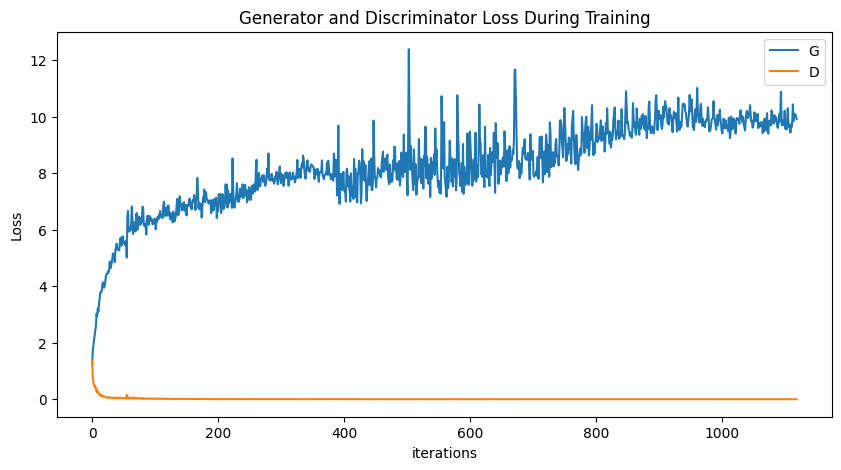

In [337]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

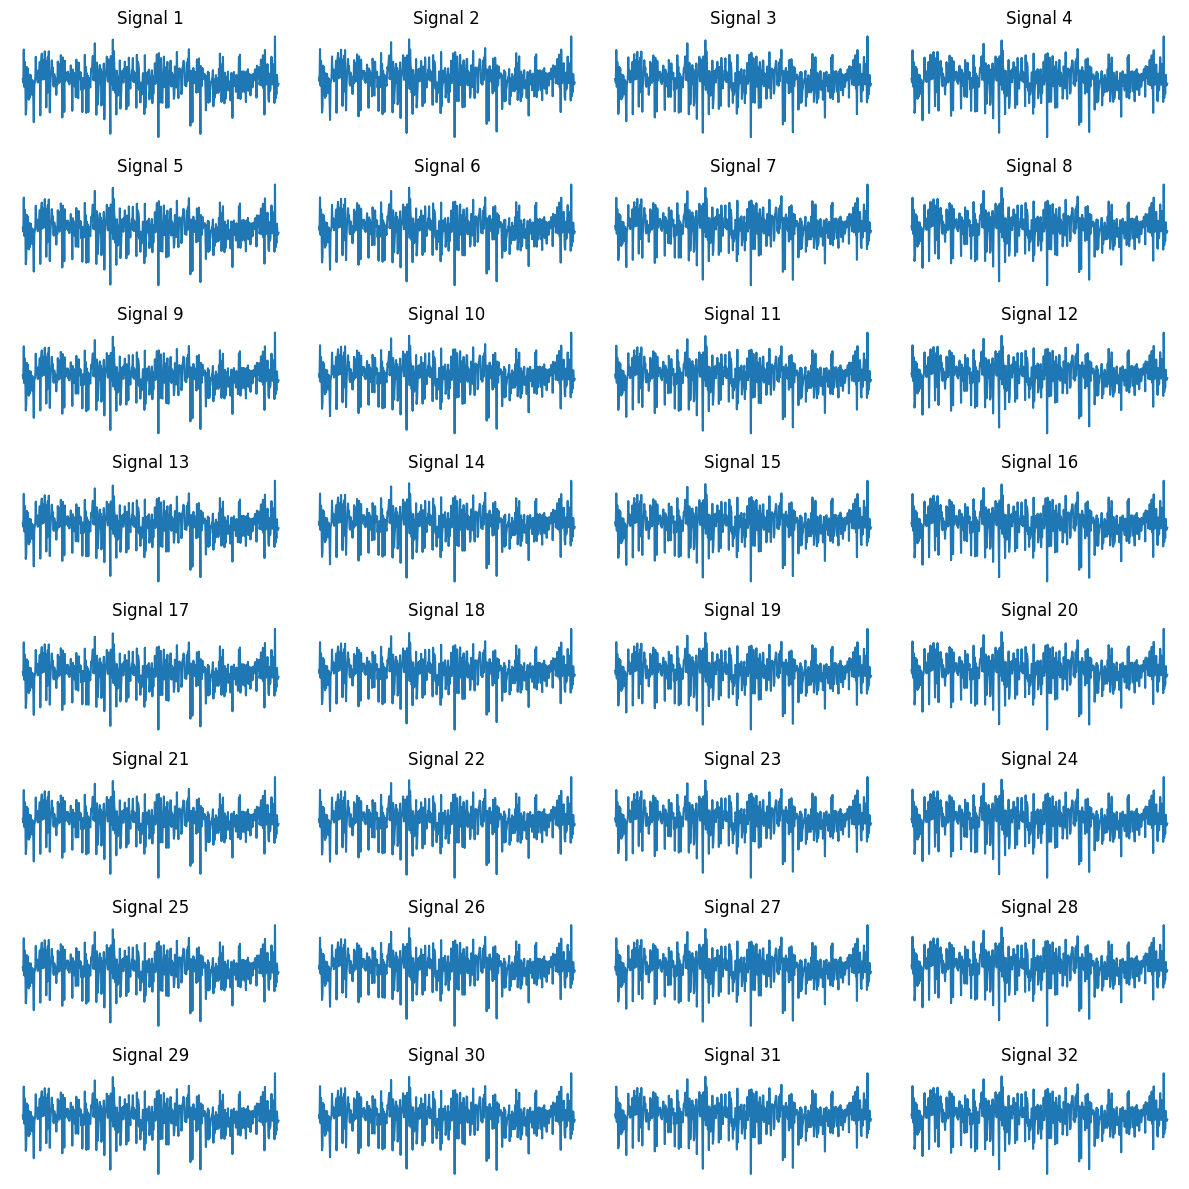

In [339]:
batch = signal_list[19]

# plotting a single batch
def plot_waveforms(batch):
    fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
    axs = axs.ravel()
    
    for i in range(len(batch)):
        signal = batch[i].squeeze()
        axs[i].plot(signal)
        axs[i].set_title(f'Signal {i+1}')
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_waveforms(batch)